<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#自动生成binding" data-toc-modified-id="自动生成binding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>自动生成binding</a></span></li><li><span><a href="#native_functions.yaml" data-toc-modified-id="native_functions.yaml-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>native_functions.yaml</a></span></li><li><span><a href="#torch.add的调用链路" data-toc-modified-id="torch.add的调用链路-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>torch.add的调用链路</a></span></li><li><span><a href="#kernel和算子注册" data-toc-modified-id="kernel和算子注册-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>kernel和算子注册</a></span></li></ul></div>

我们在日常的使用中，更多的是调用torch提供的类或函数构建模型和计算过程，那么这部分的调用逻辑是怎么样的？下面以`torch.add`为例说明常用的`torch.xxx`和`torch.nn.xxx`模块的是如何与最底层的ATen层交互的。

## 自动生成binding

与前面所述的`torch.Tensor`接口不同，`torch.xxx`和`torch.nn.xxx`的接口众多，手工一个一个添加即耗时耗力也不方便修改，所以这两个模块的pybind绑定代码以及接口的.pyi存根文件是在编译的时候自动生成的，自动生成的工具脚本就对应了`tools`目录。

此外，在pytorch中一个很重要的点是，除了上述的pybind和.pyi文件是自动生成的之外，有一些.cpp文件也是自动生成的！这是由于pytorch框架需要运行在不同的环境和硬件上，比如服务器vs手机，cpu vs gpu。在不同的环境中算子的底层实现方式是不一样的，如果手动编写这些代码就会耗费大量的人力，所以这部分的代码是自动生成的，而对应的cpp文件模板就在`tools/autograd/templates`:
+ python_functions.cpp
+ python_nn_functions.cpp
+ python_torch_functions.cpp
+ python_variable_methods.cpp
+ ...

对应的生成脚本文件就在`tools/autograd`:
+ gen_autograd_functions.py
  - Functions.h/cpp: subclasses of autograd::Node
  - python_functions.h/cpp: Python bindings for the above classes
+ gen_python_functions.py  # Generates Python bindings for ATen functions
  - torch._C._nn
  - torch._C._fft
  - torch._C._linalg
  - torch._C._nested
  - torch._C._sparse
  - torch._C._special
+ ...


我们执行如下命令来生成这些文件：
> python -m tools.autograd.gen_autograd aten/src/ATen/native/native_functions.yaml aten/src/ATen/native/tags.yaml torch/csrc/autograd/generated/ tools/autograd 

> python tools/setup_helpers/generate_code.py

> python -m tools.pyi.gen_pyi



生成的文件在`torch/csrc/autograd/generated`目录下，文件中有一些带数字下标，这表示对应的文件太大所以拆分成了几个文件同时生成，对应文件名带Everything后缀的则是这些文件代码集合。


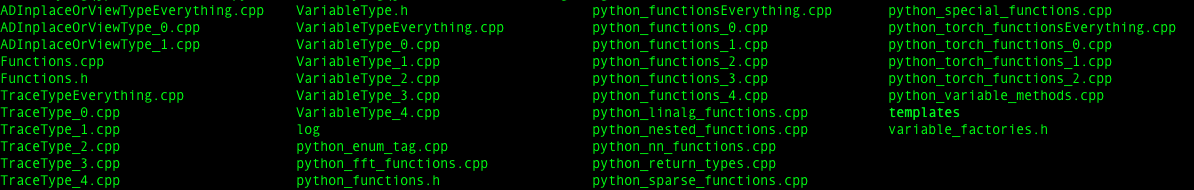

除此之外，ATen中的算子头文件和其他一些相关文件同样也是自动生成的，使用如下命令：
> python -m torchgen.gen --source-path aten/src/ATen --install_dir aten/src/ATen

生成的文件存储在`aten/src/ATen`目录中，其中的`aten/src/ATen/Functions.h`文件定义了所有算子的调用。可以在上述命令中增加`--per-operator-headers`为每一个算子单独生成对应的头文件，如`aten/src/ATen/ops/add.h`

## native_functions.yaml

如果查看上述自动生成binding和cpp文件的python文件，可以发现有一个参数指定了指向`native_functions.yaml`文件的路径，在解释这个文件之前需要说明一下pytorch的算子实现机制。

在pytorch中，所有的算子都对应了ATen中的某个底层实现，而这些实现一部分来自老的Lua torch中的实现，这部分的代码在`aten/src/THC`目录中。后来pytorch重新实现了这些算子，这些算子的头文件、dispatch机制和实现调用等都通过脚本自动实现，脚本通过`aten/src/ATen/native/native_functions.yaml`读取这些算子和其相关上述定义。


以add为例来说明native_function.yaml文件的定义。可以看到有多个不同的add函数定义，它们对应多个不同形式的torch的add函数，包括：`torch.add, torch.add_, torch.add(*, out=x)`。

```yaml
- func: add.Tensor(Tensor self, Tensor other, *, Scalar alpha=1) -> Tensor
  device_check: NoCheck   # TensorIterator
  structured_delegate: add.out
  variants: function, method
  dispatch:
    SparseCPU, SparseCUDA: add_sparse
    SparseCsrCPU, SparseCsrCUDA: add_sparse_csr
    MkldnnCPU: mkldnn_add
    ZeroTensor: add_zerotensor
    NestedTensorCPU, NestedTensorCUDA: NestedTensor_add_Tensor

- func: add_.Tensor(Tensor(a!) self, Tensor other, *, Scalar alpha=1) -> Tensor(a!)
  device_check: NoCheck   # TensorIterator
  variants: method
  structured_delegate: add.out
  dispatch:NestedTensor_add_Tensor
    SparseCPU, SparseCUDA: add_sparse_
    SparseCsrCPU, SparseCsrCUDA: add_sparse_csr_
    MkldnnCPU: mkldnn_add_
    NestedTensorCPU, NestedTensorCUDA: NestedTensor_add__Tensor

- func: add.out(Tensor self, Tensor other, *, Scalar alpha=1, Tensor(a!) out) -> Tensor(a!)
  device_check: NoCheck   # TensorIterator
  structured: True
  structured_inherits: TensorIteratorBase
  ufunc_inner_loop:
    Generic: add (AllAndComplex, BFloat16, Half, ComplexHalf)
    ScalarOnly: add (Bool)
  dispatch:
    SparseCPU: add_out_sparse_cpu
    SparseCUDA: add_out_sparse_cuda
    SparseCsrCPU: add_out_sparse_csr_cpu
    SparseCsrCUDA: add_out_sparse_csr_cuda
    MkldnnCPU: mkldnn_add_out
    MPS: add_out_mps
```

主要的配置项有：
+ func: 定义函数的schema，包括函数名称、输入参数类型、输出类型等
+ variants: 该函数是Tensor类的成员函数 (function)，还是绑定在torch上的函数(method)，两者分别对应：a.add, torch.add
+ dispatch: torch中的dispatch机制会根据tensor的类型调用不同的函数，如在CPU和GPU上的SparseCPU和SparseGPU就会调用add_sparse函数

## torch.add的调用链路

现在以`torch.add(a, b)`为例观察整个调用链路。通过pycharm的自动跳转，可以确定该函数对应了如下schema：
```python
# torch/_C/_VariableFunctions.pyi
def add(self: Tensor, alpha: Number, other: Tensor, *, out: Tensor) -> Tensor: ...
```

torch.x函数的binding通过模板`tools/autograd/templates/python_torch_functions.cpp`自动生成，得到文件`torch/csrc/autograd/generated/python_torch_functionsEverything.cpp`，在该函数中可以找到add函数的binding定义：
```c++
# torch/csrc/autograd/generated/python_torch_functionsEverything.cpp
  {"add", castPyCFunctionWithKeywords(THPVariable_add), METH_VARARGS | METH_KEYWORDS | METH_STATIC, NULL},

```

可以看到add函数绑定在`THPVariable_add`上，该函数首先解析传入的参数个数和类型，确定对应哪个版本的add，我们调用的add版本最终调用的是a的成员函数`add`：
```c++
auto dispatch_add = [](const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha) -> at::Tensor {
      pybind11::gil_scoped_release no_gil;
      // 调用的是tensor变量的add函数
      return self.add(other, alpha);
    };
    return wrap(dispatch_add(_r.tensor(0), _r.tensor(1), _r.scalar(2)));
```

根据`native_functions.yaml`文件中的定义，假设张量a和b只是CPU上定义的普通Tensor，那么就对应`NestedTensorCPU`类型，也意味着`self.add`会调用`NestedTensorCPU::NestedTensor_add_Tensor`函数。

```c++
# aten/src/ATen/native/nested/NestedTensorMath.cpp
Tensor NestedTensor_add_Tensor(
    const Tensor& self,
    const Tensor& other,
    const Scalar& alpha) {
  return NestedTensor_elementwise_Tensor(
      // 在这里传入了算子的名称
      // 调用at::add计算
      self, other, "add", [alpha](const Tensor& b1, const Tensor& b2) {
        return at::add(b1, b2, alpha);
      });
}
```

`NestedTensor_elementwise_Tensor`进一步将输入的self和other张量转换为一维数组，再进行加法运算。而函数`at::add`在自动生成的算子头文件中`aten/src/ATen/ops/add.h`:
```c++
// aten::add.Tensor(Tensor self, Tensor other, *, Scalar alpha=1) -> Tensor
inline at::Tensor add(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha=1) {
    return at::_ops::add_Tensor::call(self, other, alpha);
}
```

`add_Tensor`是一个算子结构体，在这个结构体中定义了函数在c++层级的schema、算子名称、在python层级的schema等信息：
```c++
# aten/src/ATen/MethodOperators.h
struct TORCH_API add_Tensor {
  // 函数在cpp的schema
  using schema = at::Tensor (const at::Tensor &, const at::Tensor &, const at::Scalar &);
  using ptr_schema = schema*;
  // 在这里定义了算子对应的名称是 aten::add
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(name, "aten::add")
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(overload_name, "Tensor")
  // 函数在python的schema
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(schema_str, "add.Tensor(Tensor self, Tensor other, *, Scalar alpha=1) -> Tensor")
  static at::Tensor call(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha);
  static at::Tensor redispatch(c10::DispatchKeySet dispatchKeySet, const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha);
};
```

该结构体的`call`函数找到"add"对应的函数句柄，再调用kernel层级的`add`函数进行实际的加法运算：
```c++
at::Tensor add_Tensor::call(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha) {
    // 从注册的算子/函数句柄中找到add对应的句柄
    static auto op = create_add_Tensor_typed_handle();
    // 调用kernel中的add函数
    return op.call(self, other, alpha);
}
```

## kernel和算子注册

在继续add函数的调用链路之前，先来说一下torch中的kernel和算子注册机制。所谓kernel顾名思义就是最核心的部分，也就是torch最底层的算子实现，这些在kernel定义的算子或者说函数，会通过`RegisterOperators`向“算子库”注册，包括算子的名称、schema等信息，调用者通过`op_name -> funcion_schema -> function_handler`获取函数句柄。

在C++层面可以通过下面的代码注册一个kernel算子：
```c++
 * namespace {
 *   class my_kernel_cpu final : public c10::OperatorKernel {
 *   public:
 *     Tensor operator()(Tensor a, Tensor b) {...}
 *   };
 * }
 *
 * static auto registry = c10::RegisterOperators()
 *     .op(c10::RegisterOperators::options()
 *         .schema("my_op")
 *         .kernel<my_kernel_cpu>(DispatchKey::CPU));
```

```c++

# aten/src/ATen/core/op_registration/op_registration.h
RegisterOperators& op(Options&& options) & {
    checkSchemaAndRegisterOp_(std::move(options));
    return *this;
  }


# aten/src/ATen/core/op_registration/op_registration.cpp
void RegisterOperators::checkSchemaAndRegisterOp_(Options&& options)

// 包括注册算子名称、算子定义、算子实际实现
# aten/src/ATen/core/dispatch/Dispatcher.cpp
RegistrationHandleRAII Dispatcher::registerName(OperatorName op_name)
RegistrationHandleRAII Dispatcher::registerDef(FunctionSchema schema, std::string debug, std::vector<at::Tag> tags)
RegistrationHandleRAII registerImpl(OperatorName op_name, c10::optional<DispatchKey> dispatch_key, KernelFunction kernel, c10::optional<impl::CppSignature> cpp_signature, std::unique_ptr<FunctionSchema> inferred_function_schema, std::string debug);

```

CPU上add算子的注册实现如下：
```c++
# aten/src/ATen/RegisterCPU.cpp
at::Tensor add(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha) {
return wrapper_add_Tensor(self, other, alpha);
}

at::Tensor wrapper_add_Tensor(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha) {
structured_ufunc_add_CPU_functional op;
op.meta(self, other, alpha);
op.impl(self, other, alpha, *op.outputs_[0]);
return std::move(op.outputs_[0]).take();
}
```